In [16]:
%matplotlib inline
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
from ateamopt.utils import utility
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from man_opt.cluster_score import gap_statistic
import man_opt.utils as man_utils
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

### Utility Functions

In [17]:
imshow_cmap = ListedColormap([(1, 0, 0), (1, 1, 0), (0, 1, .45)])
least_pop_index = 6
hof_num = 40

def gridsearch_kmeans(data_, ax, max_clust_num=11):
    data_ = StandardScaler().fit_transform(data_)
    clust_num_arr = range(2, max_clust_num)
    np.random.seed(0)
    gap_arr, sk_arr = [], []

    for clust_ in clust_num_arr:
        estim = KMeans(n_clusters=clust_)
        gap, sk = gap_statistic(estim, data_)
        gap_arr.append(gap)
        sk_arr.append(sk)

    gap_arr, sk_arr = np.array(gap_arr), np.array(sk_arr)
    gap_sk = gap_arr - sk_arr
    gap_diff = gap_arr[:-1] - gap_sk[1:]
    optimal_cluster_num = clust_num_arr[np.where(gap_diff > 0)[0][0]]
    inset_fontsize = 8
    axins = inset_axes(ax, width="100%", height="100%",
                       bbox_to_anchor=(.15, .8, .35, .2),
                       bbox_transform=ax.transAxes, loc=2)

    axins.plot(clust_num_arr, gap_arr, lw=1)
    axins.vlines(optimal_cluster_num, axins.get_ylim()
                 [0], axins.get_ylim()[1], lw=.8)
    axins.grid(False)
    axins.set_xticks(range(2, max_clust_num, 2))
    axins.set_xticklabels([str(clust) for clust in range(2, max_clust_num, 2)],
                          fontsize=inset_fontsize)
    plt.setp(axins.get_yticklabels(), fontsize=inset_fontsize)
    axins.set_xlabel('# of clusters', fontsize=inset_fontsize, labelpad=1)
    axins.set_ylabel('gap statistic', fontsize=inset_fontsize, labelpad=1)
    axins.tick_params(axis='x', pad=-3)
    axins.tick_params(axis='y', pad=-3)
    return optimal_cluster_num


def draw_kmeans_decision_boundary(data_, nclusters, ax, h=5e-2):

    # Plot the decision boundary. For that, we will assign a color to each
    scaler = StandardScaler()
    data_ = scaler.fit_transform(data_)
    x_min, x_max = data_[:, 0].min() - 1, data_[:, 0].max() + 1
    y_min, y_max = data_[:, 1].min() - 1, data_[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    kmeans = KMeans(n_clusters=nclusters)
    kmeans.fit(data_)
    Z = kmeans.predict(
        np.array(np.c_[xx.ravel(), yy.ravel()]))

    inv_scaler_transform = scaler.inverse_transform(
        np.c_[xx.ravel(), yy.ravel()])
    xx = inv_scaler_transform[:, 0].reshape(xx.shape)
    yy = inv_scaler_transform[:, 1].reshape(yy.shape)
    Z = Z.reshape(xx.shape)
    Z_rearranged = np.zeros_like(Z)

    Z_corners = [Z[0, 0], Z[0, -1], Z[-1, -1]]
    for i, z_val in enumerate(Z_corners):
        Z_rearranged[Z == z_val] = i

    ax.imshow(Z_rearranged, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=imshow_cmap, alpha=.1,
              aspect='auto', origin='lower')


def filter_for_ttype(df, me_ttype_map, exc_subclass, inh_subclass, select_ttypes=None):
    df['me_type'] = df['me_type'].fillna('Other')
    df['ttype'] = df['me_type'].apply(lambda x: me_ttype_map[x])
    if select_ttypes:
        df = df.loc[df.ttype.isin(select_ttypes), ]
    df['ttype'] = df['ttype'].apply(lambda x: 'Pyr' if x in exc_subclass
                                    else(x if x in inh_subclass else 'Other'))
    return df

### Data Paths

In [18]:
data_path = os.path.join(os.getcwd(), os.pardir,
                         os.pardir, 'assets', 'aggregated_data')
mouse_data_filename = os.path.join(data_path, 'Mouse_class_data.csv')
mouse_datatype_filename = os.path.join(data_path, 'Mouse_class_datatype.csv')
train_ephys_max_amp_filename = os.path.join(
    data_path, 'train_ephys_max_amp.csv')
train_ephys_max_amp_dtype_filename = os.path.join(
    data_path, 'train_ephys_max_amp_dtype.csv')
train_ephys_max_amp_fields_filename = os.path.join(
    data_path, 'train_ephys_max_amp_fields.json')
hof_model_ephys_max_amp_filename = os.path.join(
    data_path, 'hof_model_ephys_max_amp.csv')
hof_model_ephys_max_amp_dtype_filename = os.path.join(data_path,
                                                      'hof_model_ephys_max_amp_datatype.csv')
me_ttype_map_path = os.path.join(data_path, 'me_ttype.pkl')
param_data_filename = os.path.join(data_path, 'allactive_params.csv')
param_datatype_filename = os.path.join(
    data_path, 'allactive_params_datatype.csv')

### Load data

In [19]:
mouse_data_df = man_utils.read_csv_with_dtype(
    mouse_data_filename, mouse_datatype_filename)
bcre_cluster = mouse_data_df.loc[mouse_data_df.hof_index == 0, [
    'Cell_id', 'Broad_Cre_line', 'me_type']]

ephys_data = man_utils.read_csv_with_dtype(train_ephys_max_amp_filename,
                                           train_ephys_max_amp_dtype_filename)
model_ephys_data = man_utils.read_csv_with_dtype(hof_model_ephys_max_amp_filename,
                                                 hof_model_ephys_max_amp_dtype_filename)
hof_param_data = man_utils.read_csv_with_dtype(
    param_data_filename, param_datatype_filename)

me_ttype_map = utility.load_pickle(me_ttype_map_path)
me_ttype_map = {**me_ttype_map, 'Other': 'Other'}
broad_subclass_order = ['Other', 'Pyr', 'Pvalb', 'Sst', 'Vip']
broad_subclass_colors = ['#D3D3D30D',
                         '#009B81', '#D93137', '#F15A29', '#70559A']
cmap = ListedColormap(broad_subclass_colors)

### Aggregate Ephys data

In [20]:
exc_subclass = ['L2/3 IT', 'L4', 'L5 IT',
                'L5 PT', 'NP', 'L6 IT', 'L6 CT', 'L6b']
inh_subclass = ['Vip', 'Sst', 'Pvalb']

target_field = 'ttype'
efeat_max_df = ephys_data.drop(labels=['stim_name', 'amp'], axis=1)
df_exp_efeat_max = pd.merge(efeat_max_df, bcre_cluster, how='left',
                            on='Cell_id')


df_exp_efeat_max = filter_for_ttype(
    df_exp_efeat_max, me_ttype_map, exc_subclass, inh_subclass)
ephys_X_df, ephys_y_df, revised_features = man_utils.prepare_data_clf(df_exp_efeat_max, list(efeat_max_df), target_field,
                                                                      least_pop=least_pop_index)
ephys_features = [feature_ for feature_ in revised_features
                  if feature_ != 'Cell_id']

ephys_X_data = ephys_X_df.loc[:, ephys_features].values
ephys_y_df['label_encoder'] = ephys_y_df[target_field].apply(
    lambda x: broad_subclass_order.index(x))

### Fit UMAP (on experimental features)

In [21]:
exp_feature_embedding_path = os.path.join(data_path, 'efeat_exp_umap_embedding.csv')
if not os.path.exists(exp_feature_embedding_path):
    umap_pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('umap', UMAP(n_neighbors=10, random_state=0))])
    umap_ = umap_pipeline.fit(ephys_X_data)  # Experimental ephys
    efeature_exp = pd.concat([ephys_X_df, ephys_y_df], axis=1)
    efeature_exp['x-umap'] = umap_.named_steps['umap'].embedding_[:, 0]
    efeature_exp['y-umap'] = umap_.named_steps['umap'].embedding_[:, 1]

    # save the exp efeature transform
    efeature_exp.to_csv(exp_feature_embedding_path, index=False)
else:
    efeature_exp = pd.read_csv(exp_feature_embedding_path, index_col=None)

### Transform new data (Features of all hof models)

In [22]:
model_feature_embedding_path = os.path.join(data_path, 'efeat_model_umap_embedding.csv')
if not os.path.exists(model_feature_embedding_path):
    df_model_efeat_max = pd.merge(model_ephys_data, bcre_cluster, how='left',
                                  on='Cell_id')

    df_model_efeat_max = filter_for_ttype(df_model_efeat_max, me_ttype_map,
                                          exc_subclass, inh_subclass)

    mephys_X_df, mephys_y_df, revised_features = man_utils.prepare_data_clf(df_model_efeat_max,
                                                                            list(
                                                                                model_ephys_data),
                                                                            target_field, least_pop=hof_num * least_pop_index)
    e_features = [feature_ for feature_ in revised_features if feature_ not in [
        'Cell_id', 'hof_index']]

    hof_ephys_data = mephys_X_df.loc[:, e_features].values
    mephys_y_df['label_encoder'] = mephys_y_df[target_field].apply(
        lambda x: broad_subclass_order.index(x))
    hof_efeat_embedding = pd.concat([mephys_X_df, mephys_y_df], axis=1)
    hof_efeat_transform = umap_pipeline.transform(hof_ephys_data)
    hof_efeat_embedding['x-umap'] = hof_efeat_transform[:, 0]
    hof_efeat_embedding['y-umap'] = hof_efeat_transform[:, 1]

    # save the model efeature transform
    hof_efeat_embedding.to_csv(model_feature_embedding_path, index=False)
else:
    hof_efeat_embedding = pd.read_csv(model_feature_embedding_path, index_col=None)

### hof model parameter embedding

In [23]:
param_embedding_path = os.path.join(data_path, 'param_umap_embedding.csv')
if not os.path.exists(param_embedding_path):
    ttype_cluster = df_exp_efeat_max.loc[:, ['Cell_id', 'ttype']]
    hof_param_data = pd.merge(
        hof_param_data, ttype_cluster, how='left', on='Cell_id')
    m_X_df, m_y_df, revised_features = man_utils.prepare_data_clf(hof_param_data, [param_ for param_ in list(
        hof_param_data) if param_ != target_field], target_field,
        least_pop=hof_num * least_pop_index)
    m_y_df['label_encoder'] = m_y_df[target_field].apply(
        lambda x: broad_subclass_order.index(x))
    param_features = [
        feature_ for feature_ in revised_features if feature_ not in ['Cell_id', 'hof_index']]
    hof_params = m_X_df.loc[:, param_features].values
    hof_param_embedding = pd.concat([m_X_df, m_y_df], axis=1)

    umap_pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('umap', UMAP(n_neighbors=hof_num * 10, random_state=0))])

    param_transform = umap_pipeline.fit_transform(hof_params)
    hof_param_embedding['x-umap'] = param_transform[:, 0]
    hof_param_embedding['y-umap'] = param_transform[:, 1]

    # save the param umap transform since it takes a long time to calculate
    hof_param_embedding.to_csv(param_embedding_path, index=False)
else:
    hof_param_embedding = pd.read_csv(param_embedding_path, index_col=None)

### Plotting

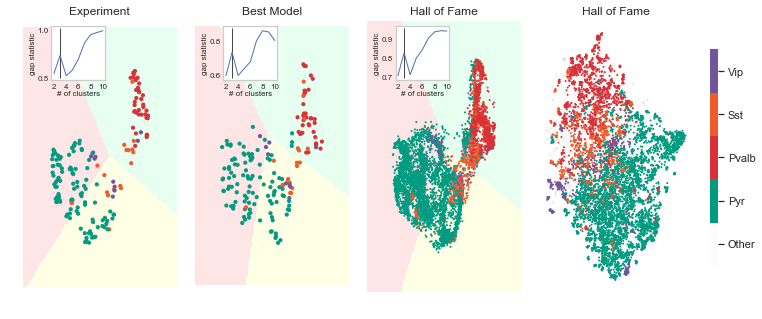

In [24]:
title_list = ['Experiment', 'Best Model', 'Hall of Fame', 'Hall of Fame']
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(
    0, len(broad_subclass_order) - 1))
sm.set_array([])

sns.set(style='whitegrid')
fig = plt.figure(figsize=(12, 5))
ax_0 = fig.add_subplot(1, 4, 1)
ax_0.scatter(efeature_exp['x-umap'], efeature_exp['y-umap'], s=10, c=efeature_exp['label_encoder'],
             cmap=cmap)
nclusters = gridsearch_kmeans(
    efeature_exp.loc[:, ['x-umap', 'y-umap']].values, ax_0)
draw_kmeans_decision_boundary(
    efeature_exp.loc[:, ['x-umap', 'y-umap']].values, nclusters, ax_0)

ax_1 = fig.add_subplot(1, 4, 2, sharey=ax_0)
ax_1.scatter(hof_efeat_embedding.loc[hof_efeat_embedding.hof_index == 0, 'x-umap'],
             hof_efeat_embedding.loc[hof_efeat_embedding.hof_index == 0, 'y-umap'], s=10, c=hof_efeat_embedding.loc[hof_efeat_embedding.hof_index == 0,
                                                                                                                    'label_encoder'], cmap=cmap)
nclusters = gridsearch_kmeans(hof_efeat_embedding.loc[hof_efeat_embedding.hof_index == 0, [
    'x-umap', 'y-umap']].values, ax_1)
draw_kmeans_decision_boundary(hof_efeat_embedding.loc[hof_efeat_embedding.hof_index == 0, ['x-umap', 'y-umap']].values,
                              nclusters, ax_1)
ax_2 = fig.add_subplot(1, 4, 3, sharey=ax_0)
ax_2.scatter(hof_efeat_embedding['x-umap'], hof_efeat_embedding['y-umap'], s=1, c=hof_efeat_embedding['label_encoder'],
             cmap=cmap)
nclusters = gridsearch_kmeans(
    hof_efeat_embedding.loc[:, ['x-umap', 'y-umap']].values, ax_2)
draw_kmeans_decision_boundary(
    hof_efeat_embedding.loc[:, ['x-umap', 'y-umap']].values, nclusters, ax_2)

ax_3 = fig.add_subplot(1, 4, 4)
ax_3.scatter(hof_param_embedding['x-umap'], hof_param_embedding['y-umap'], s=1,
             c=hof_param_embedding['label_encoder'], cmap=cmap)

fig.subplots_adjust(wspace=.12)

ax = [ax_0, ax_1, ax_2, ax_3]
for jj, ax_ in enumerate(ax):
    ax_.axis('off')
    ax_.set_title(title_list[jj])
    main_ax_ylim = ax_.get_ylim()
cax = fig.add_axes([0.92, 0.2, 0.01, .6])
cbar = plt.colorbar(sm, boundaries=np.arange(
    len(broad_subclass_order) + 1) - 0.5, cax=cax)
cbar.set_ticks(np.arange(len(broad_subclass_order)))
cbar.ax.set_yticklabels(broad_subclass_order)
cbar.outline.set_visible(False)
plt.show()